In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine, MetaData, Table
import psycopg2

In [54]:
# подгружаем .env
load_dotenv()

True

In [55]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [56]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_denis_putov_www" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [57]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(5)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
2,3,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1
3,4,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,0
4,5,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Предполагаем, что DataFrame df уже загружен
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)

# График 1: Распределение по type
x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
axs[0,0].set_title(f'Count {y} by {x}')

# График 2: Распределение по payment_method
x = "payment_method"
y = "customer_id"
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])
axs[0,1].set_title(f'Count {y} by {x}')
axs[0,1].set_xticklabels(agg_df[x], rotation=45, ha='right')

# График 3: Распределение по internet_service
x = "internet_service"
y = "customer_id"
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0])
axs[1,0].set_title(f'Count {y} by {x}')

# График 4: Распределение по gender

x = "gender"
y = "customer_id"
agg_df = df.groupby(x)[y].agg(stat).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])
axs[1,1].set_title(f'Count {y} by {x}')

fig.tight_layout(pad=1.6)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))
plt.close()

/tmp/ipykernel_89465/2816551476.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(agg_df[x], rotation=45, ha='right')


In [59]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count']
print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv   
0                No            No                No           No           No  \
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

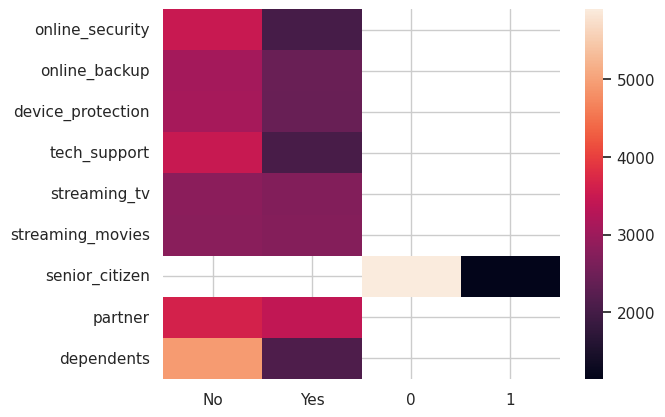

In [60]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))


MultiIndex([(     'begin_date',           ''),
            ('monthly_charges',       'mean'),
            ('monthly_charges',     'median'),
            ('monthly_charges', '<lambda_0>')],
           )
   begin_date monthly_charges                    
                         mean   median <lambda_0>
0  2013-10-01      104.800000  104.150      92.45
1  2013-11-01      108.325000  108.325     108.05
2  2013-12-01       91.066667   93.700      65.30
3  2014-01-01       95.864286  104.050      54.20
4  2014-02-01       80.934153   89.475      24.75
..        ...             ...      ...        ...
71 2019-09-01       59.490928   69.350      20.20
72 2019-10-01       56.259705   58.500      19.95
73 2019-11-01       54.602110   55.800      20.20
74 2019-12-01       52.312955   54.050      19.90
75 2020-01-01       37.909013   25.400      19.75

[76 rows x 4 columns]


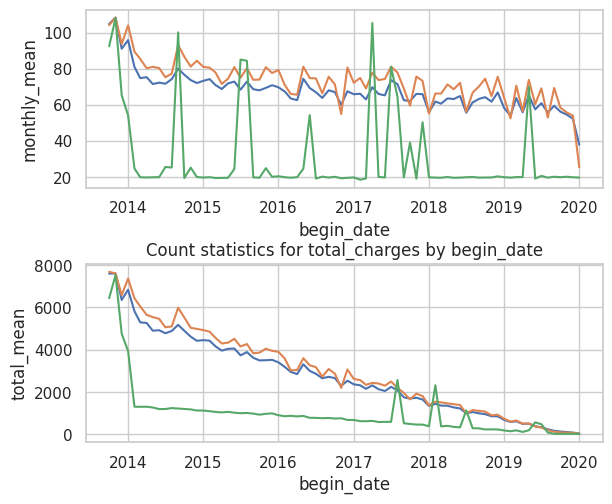

In [61]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
print(charges_monthly_agg.columns)
print(charges_monthly_agg)

# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(6.5, 5.5)
fig.tight_layout(pad=2.5)

sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
# Построение графиков для общих платежей

# построение линейных графиков для общих платежей

# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# Сохранение графика
assets_dir = os.getenv('ASSETS_DIR', './assets')
os.makedirs(assets_dir, exist_ok=True)
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

   target  count
0       0   5163
1       1   1869


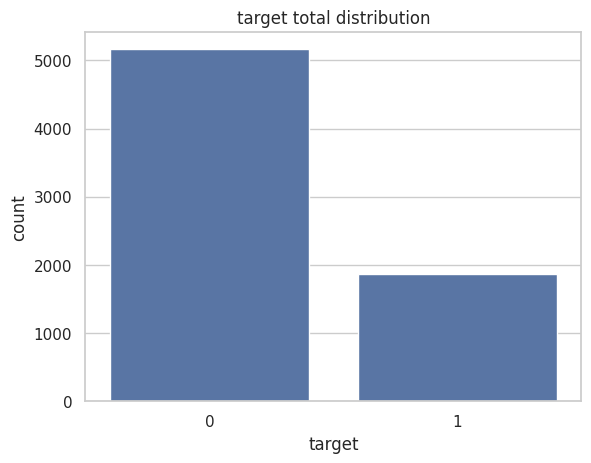

In [62]:
# директория для сохранения картинок

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)
# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()
print(target_agg)
# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(data=target_agg, x='target', y='count')

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))


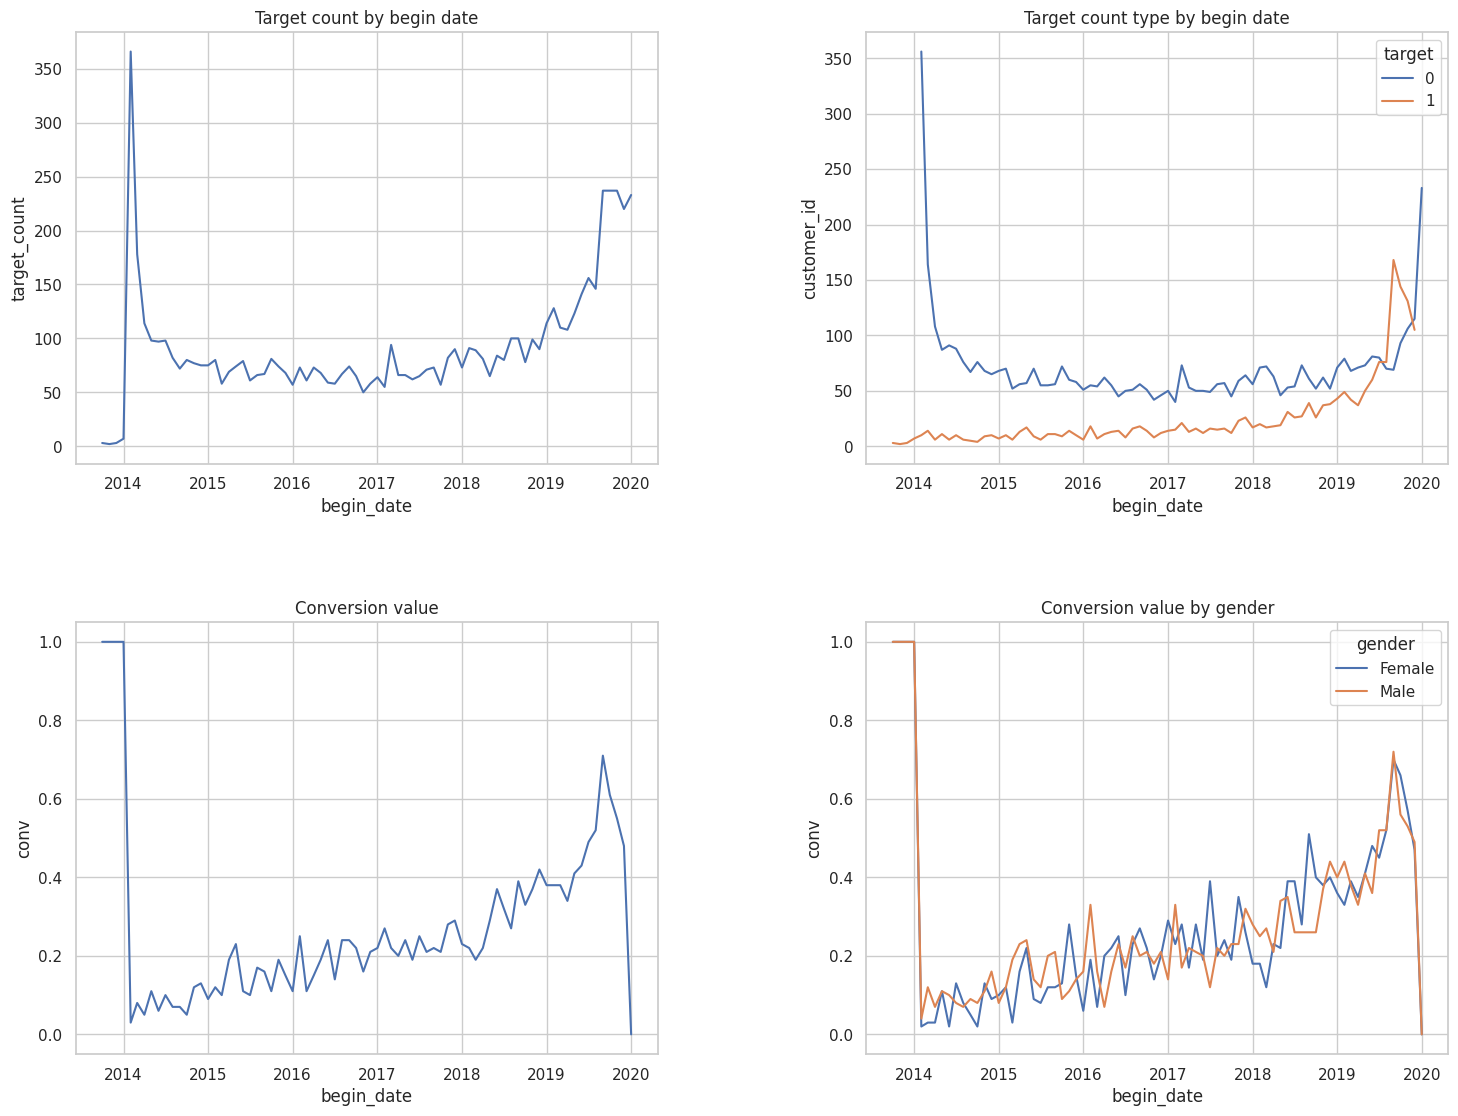

In [63]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)
# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)
# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

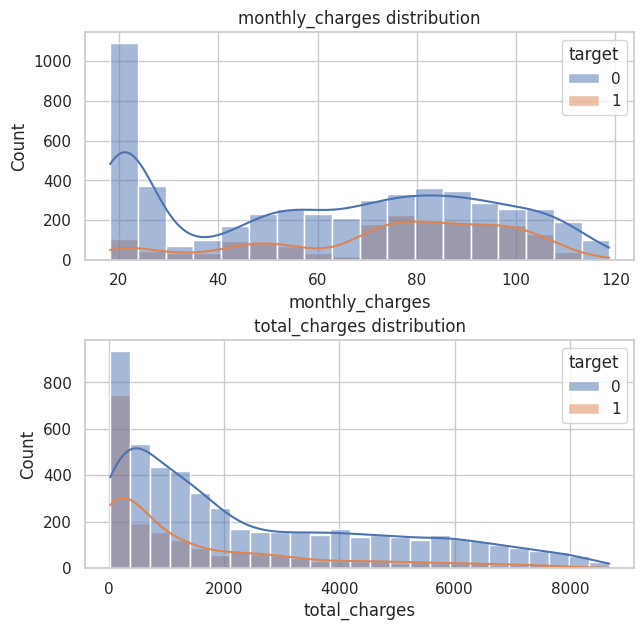

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# Инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # Настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5)  # Установка размера фигуры

# Визуализация распределения ежемесячных платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
axs[0].set_title(f"{charges[0]} distribution")  # Установка заголовка для гистограммы

# Визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# Сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))


In [65]:
os.environ.update({
    "MLFLOW_S3_ENDPOINT_URL": "https://storage.yandexcloud.net",
    "AWS_ACCESS_KEY_ID": os.getenv("AWS_ACCESS_KEY_ID"),  # Убедитесь, что переменные окружения установлены
    "AWS_SECRET_ACCESS_KEY": os.getenv("AWS_SECRET_ACCESS_KEY"),
})

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)